# Forecasting and modeling for hourly demand of taxis

The following code was edited and debugged by using ChatGPT.

In [1]:
# Import the required packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Import required machine learning packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Load the datasets
events_df = pd.read_csv('../data/curated/events/nyc_hourly_events_precinct_borough.csv')
pu_do_df = pd.read_csv('../data/curated/taxi/hourly_pu_do_counts_location.csv')
weather_df = pd.read_csv('../data/curated/weather/weather_cleaned.csv')
mapping_df = pd.read_csv('../data/curated/taxi_zone_to_precinct_mapping.csv')


### Merge the three datasets together

In [3]:
# Merge taxi data with mapping to associate taxi zones with precincts
pu_do_df = pd.merge(pu_do_df, mapping_df, left_on='location_id', right_on='LocationID', how='left')

# Aggregate events data by date, hour, and precinct
events_agg_df = events_df.groupby(['event_date', 'hour', 'police_precinct']).agg({
    'event_count': 'sum',
    'event_borough': 'first'
}).reset_index()

# Merge the enriched taxi data with the aggregated events data
merged_df = pd.merge(pu_do_df, events_agg_df, 
                     left_on=['date', 'hour', 'Precinct'], 
                     right_on=['event_date', 'hour', 'police_precinct'], 
                     how='left')

# Merge with weather data
final_df = pd.merge(merged_df, weather_df, on='date', how='left')

# Create 'month' and 'day_of_week' columns
final_df['month'] = pd.to_datetime(final_df['date']).dt.month
final_df['day_of_week'] = pd.to_datetime(final_df['date']).dt.dayofweek

# Fill any missing values with 0
final_df.fillna(0, inplace=True)

final_df.head()

,date,hour,location_id,pickup_trip_count,dropoff_trip_count,LocationID,Precinct,event_date,police_precinct,event_count,...,max_temp,min_temp,avg_wind_sp,avg_rel_humi,fog,heavy_fog,thunder,avg_temp,month,day_of_week
0,2023-01-01,0,43,87,26,43.0,22.0,0,0.0,0.0,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6
1,2023-01-01,0,45,8,11,45.0,5.0,2023-01-01,5.0,1.0,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6
2,2023-01-01,0,75,14,59,75.0,23.0,0,0.0,0.0,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6
3,2023-01-01,0,106,0,2,106.0,78.0,0,0.0,0.0,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6
4,2023-01-01,0,113,54,40,113.0,6.0,0,0.0,0.0,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6


#### Fill the boroughs based on the precinct
Even in cases where there aren't any events

In [4]:
# Load the precinct-to-borough mapping
precinct_borough_df = pd.read_csv('../data/curated/precinct_to_borough_mapping.csv')

# Convert the DataFrame to a dictionary
precinct_to_borough = dict(zip(precinct_borough_df['police_precinct'], precinct_borough_df['event_borough']))

# Define a function to map precincts to boroughs
def get_borough(precinct):
    return precinct_to_borough.get(precinct, 'Unknown')

# Apply the mapping to fill in missing boroughs based on precincts in your merged DataFrame
final_df['event_borough'] = final_df.apply(
    lambda row: get_borough(row['Precinct']) if row['event_borough'] == 0 else row['event_borough'], axis=1
)

# Drop the 'police_precinct' column if it's no longer needed
final_df.drop(columns=['police_precinct'], inplace=True)

# Display the updated DataFrame
final_df.head()


,date,hour,location_id,pickup_trip_count,dropoff_trip_count,LocationID,Precinct,event_date,event_count,event_borough,...,max_temp,min_temp,avg_wind_sp,avg_rel_humi,fog,heavy_fog,thunder,avg_temp,month,day_of_week
0,2023-01-01,0,43,87,26,43.0,22.0,0,0.0,Brooklyn,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6
1,2023-01-01,0,45,8,11,45.0,5.0,2023-01-01,1.0,Manhattan,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6
2,2023-01-01,0,75,14,59,75.0,23.0,0,0.0,Bronx,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6
3,2023-01-01,0,106,0,2,106.0,78.0,0,0.0,Staten Island,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6
4,2023-01-01,0,113,54,40,113.0,6.0,0,0.0,Queens,...,128.0,94.0,22.0,64.0,1.0,0.0,0.0,111.0,1,6


### Encode the boroughs as they are categorical

In [5]:
# One-hot encode boroughs
encoder = OneHotEncoder()
encoded_boroughs = encoder.fit_transform(final_df[['event_borough']])

# Convert to DataFrame and concatenate
encoded_boroughs_df = pd.DataFrame(encoded_boroughs.toarray(), columns=encoder.get_feature_names_out(['event_borough']))
final_df = pd.concat([final_df.reset_index(drop=True), encoded_boroughs_df], axis=1)

# Drop the original borough column
final_df.drop(columns=['event_borough'], inplace=True)

# Fill missing lag values with 0
final_df.fillna(0, inplace=True)

final_df.head()


,date,hour,location_id,pickup_trip_count,dropoff_trip_count,LocationID,Precinct,event_date,event_count,precip,...,thunder,avg_temp,month,day_of_week,event_borough_Bronx,event_borough_Brooklyn,event_borough_Manhattan,event_borough_Queens,event_borough_Staten Island,event_borough_Unknown
0,2023-01-01,0,43,87,26,43.0,22.0,0,0.0,0,...,0.0,111.0,1,6,0.0,1.0,0.0,0.0,0.0,0.0
1,2023-01-01,0,45,8,11,45.0,5.0,2023-01-01,1.0,0,...,0.0,111.0,1,6,0.0,0.0,1.0,0.0,0.0,0.0
2,2023-01-01,0,75,14,59,75.0,23.0,0,0.0,0,...,0.0,111.0,1,6,1.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01,0,106,0,2,106.0,78.0,0,0.0,0,...,0.0,111.0,1,6,0.0,0.0,0.0,0.0,1.0,0.0
4,2023-01-01,0,113,54,40,113.0,6.0,0,0.0,0,...,0.0,111.0,1,6,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
final_df.head()

,date,hour,location_id,pickup_trip_count,dropoff_trip_count,LocationID,Precinct,event_date,event_count,precip,...,thunder,avg_temp,month,day_of_week,event_borough_Bronx,event_borough_Brooklyn,event_borough_Manhattan,event_borough_Queens,event_borough_Staten Island,event_borough_Unknown
0,2023-01-01,0,43,87,26,43.0,22.0,0,0.0,0,...,0.0,111.0,1,6,0.0,1.0,0.0,0.0,0.0,0.0
1,2023-01-01,0,45,8,11,45.0,5.0,2023-01-01,1.0,0,...,0.0,111.0,1,6,0.0,0.0,1.0,0.0,0.0,0.0
2,2023-01-01,0,75,14,59,75.0,23.0,0,0.0,0,...,0.0,111.0,1,6,1.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01,0,106,0,2,106.0,78.0,0,0.0,0,...,0.0,111.0,1,6,0.0,0.0,0.0,0.0,1.0,0.0
4,2023-01-01,0,113,54,40,113.0,6.0,0,0.0,0,...,0.0,111.0,1,6,0.0,0.0,0.0,1.0,0.0,0.0


#### Drop columns not needed for modeling

In [7]:
final_df.drop(columns=['LocationID', 'event_date', 'dropoff_trip_count', 'location_id'], inplace=True)

In [8]:
final_df.head()

,date,hour,pickup_trip_count,Precinct,event_count,precip,snowfall,max_temp,min_temp,avg_wind_sp,...,thunder,avg_temp,month,day_of_week,event_borough_Bronx,event_borough_Brooklyn,event_borough_Manhattan,event_borough_Queens,event_borough_Staten Island,event_borough_Unknown
0,2023-01-01,0,87,22.0,0.0,0,0.0,128.0,94.0,22.0,...,0.0,111.0,1,6,0.0,1.0,0.0,0.0,0.0,0.0
1,2023-01-01,0,8,5.0,1.0,0,0.0,128.0,94.0,22.0,...,0.0,111.0,1,6,0.0,0.0,1.0,0.0,0.0,0.0
2,2023-01-01,0,14,23.0,0.0,0,0.0,128.0,94.0,22.0,...,0.0,111.0,1,6,1.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01,0,0,78.0,0.0,0,0.0,128.0,94.0,22.0,...,0.0,111.0,1,6,0.0,0.0,0.0,0.0,1.0,0.0
4,2023-01-01,0,54,6.0,0.0,0,0.0,128.0,94.0,22.0,...,0.0,111.0,1,6,0.0,0.0,0.0,1.0,0.0,0.0


Note: I one hot encoded the precinct but it doesn't make for a better mode, and only increases the complexity.

Because of that, i decided to keep it as it is

In [9]:
# # One-hot encode precincts
# encoder_precinct = OneHotEncoder(drop='first')  # drop='first' to avoid multicollinearity
# encoded_precinct = encoder_precinct.fit_transform(final_df[['Precinct']])

# # Convert to DataFrame and concatenate with the main DataFrame
# encoded_precinct_df = pd.DataFrame(encoded_precinct.toarray(), columns=encoder_precinct.get_feature_names_out(['Precinct']))
# final_df = pd.concat([final_df.reset_index(drop=True), encoded_precinct_df], axis=1)

# # Drop the original 'Precinct' column
# final_df.drop(columns=['Precinct'], inplace=True)

### Split the dataset into training and testing 
Train data: 2023

Test data: 2024

In [10]:
# Split the data into 2023 and 2024 subsets
train_df = final_df[final_df['date'].str.contains('2023')]
test_df = final_df[final_df['date'].str.contains('2024')]

# Drop the date column for modeling
train_df.drop(columns=['date'], inplace=True)
test_df.drop(columns=['date'], inplace=True)

# Split the data into features (X) and target (y)
X_train = train_df.drop(columns=['pickup_trip_count'])
y_train = train_df['pickup_trip_count']

X_test = test_df.drop(columns=['pickup_trip_count'])
y_test = test_df['pickup_trip_count']

/var/folders/bz/yjywszk15kxc8d5vv73k9xcc0000gn/T/ipykernel_38998/3832497778.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['date'], inplace=True)
/var/folders/bz/yjywszk15kxc8d5vv73k9xcc0000gn/T/ipykernel_38998/3832497778.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['date'], inplace=True)


In [11]:
X_train.head(10)

,hour,Precinct,event_count,precip,snowfall,max_temp,min_temp,avg_wind_sp,avg_rel_humi,fog,...,thunder,avg_temp,month,day_of_week,event_borough_Bronx,event_borough_Brooklyn,event_borough_Manhattan,event_borough_Queens,event_borough_Staten Island,event_borough_Unknown
0,0,22.0,0.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,0.0,1.0,0.0,0.0,0.0,0.0
1,0,5.0,1.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,0.0,0.0,1.0,0.0,0.0,0.0
2,0,23.0,0.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,1.0,0.0,0.0,0.0,0.0,0.0
3,0,78.0,0.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,0.0,0.0,0.0,0.0,1.0,0.0
4,0,6.0,0.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,0.0,0.0,0.0,1.0,0.0,0.0
5,0,41.0,0.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,0.0,0.0,1.0,0.0,0.0,0.0
6,0,5.0,1.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,0.0,0.0,1.0,0.0,0.0,0.0
7,0,24.0,0.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,1.0,0.0,0.0,0.0,0.0,0.0
8,0,40.0,0.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,0.0,0.0,0.0,0.0,1.0,0.0
9,0,72.0,0.0,0,0.0,128.0,94.0,22.0,64.0,1.0,...,0.0,111.0,1,6,0.0,0.0,0.0,0.0,1.0,0.0


### Trying to find the best value of lambda for the LASSO Regression

Note: Doing the following step did not really have an effect on the LASSO model so it's not really necessary

In [12]:
from sklearn.linear_model import LassoCV

# Define a range of alpha values
alphas = np.logspace(-4, 0, 50)

# Perform cross-validation to find the best alpha
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# Best alpha value
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")


Best alpha: 0.0001


/Users/salehakhalid/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e+09, tolerance: 1.246e+06
  model = cd_fast.enet_coordinate_descent(


## Fit the models and calculate some evaluation metrics for comparison

In [13]:
# Model 1: Lasso Regression
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate Lasso Regression
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print(f'Lasso Regression – MSE: {mse_lasso}, R^2: {r2_lasso}, RMSE: {np.sqrt(mse_lasso)}, MAE: {mae_lasso}')

# Model 2: Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate Gradient Boosting Regressor
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
print(f'Gradient Boosting Regressor – MSE: {mse_gbr}, R^2: {r2_gbr}, RMSE: {np.sqrt(mse_gbr)}, MAE: {mae_gbr}')

/Users/salehakhalid/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e+09, tolerance: 1.246e+06
  model = cd_fast.enet_coordinate_descent(


Lasso Regression – MSE: 4451.161118295494, R^2: -0.13266705987971772, RMSE: 66.7170227025719, MAE: 51.5754687082582
Gradient Boosting Regressor – MSE: 3592.7509725367145, R^2: 0.08576873027200838, RMSE: 59.93956099719712, MAE: 34.70674138280494


## Plot the average predictions of both models compared to actual

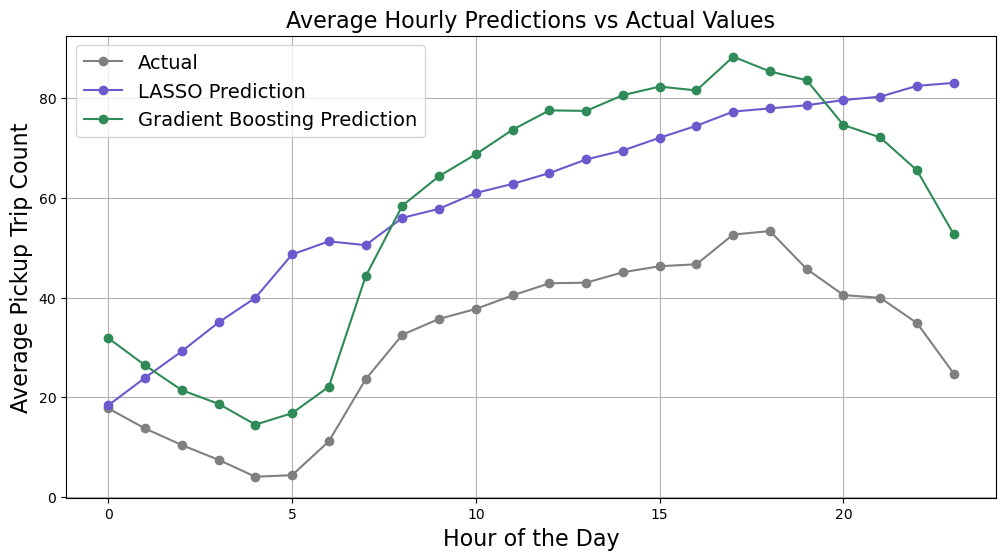

In [14]:
# Create a DataFrame to hold the predictions and actual values
predictions_df = pd.DataFrame({
    'hour': X_test['hour'],
    'actual': y_test,
    'lasso_prediction': y_pred_lasso,
    'gbr_prediction': y_pred_gbr
})

# Group by hour to calculate the mean for each hour
hourly_comparison = predictions_df.groupby('hour').mean()

# Plotting the average hourly predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(hourly_comparison.index, hourly_comparison['actual'], label='Actual', marker='o', color="gray")
plt.plot(hourly_comparison.index, hourly_comparison['lasso_prediction'], label='LASSO Prediction', marker='o', color="slateblue")
plt.plot(hourly_comparison.index, hourly_comparison['gbr_prediction'], label='Gradient Boosting Prediction', marker='o', color="seagreen")
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Average Pickup Trip Count', fontsize=16)
plt.title('Average Hourly Predictions vs Actual Values', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("../plots/predictions.png", dpi=300, bbox_inches='tight')
plt.show()